# 3. Feladatsor
*(Normálegyenlet, iteratív megoldók, gradiens-ereszkedés)*

## Normálegyenlet

Az $Ax = b$ egyenlet $\| \cdot \|_2$ szerinti legjobb megoldása, azaz a $b$ vektor vetülete $\operatorname{ran}(A)$-ra. Ekkor az $Ax - b$ hibavektor merőleges az $A$ képterére, azaz $A^*$ magjában van, tehát
$$
A^*(Ax -b) = 0.
$$

### 1. Feladat

Legyen
$$
A = \begin{bmatrix}
    1 & 0 \\
    0 & 1 \\
    0 & 0
    \end{bmatrix}.
$$

a) Mi $A$ képtere?

b) Mi $A^*$ magja?

c) Mi az $A x = [1, 1, 1]^T$ 2-es norma szerinti legjobb megoldása, geometrialiag?

d) Írjuk fel a normálegyenletet és oldjuk is meg.

## Iteratív megoldók

**Tétel (Banach-fixpont)**: Ha $X$ teljes metrikus tér, $f: X \to X$ kontrakció, akkor $f$-nek pontosan egy fixpontja van, továbbá tetszőleges $x_0$  esetén az $x_{n+1} = f(x_n)$ képlettel definiált sorozat tart ehhez a fixponthoz.

**Következmény:** Ha $f: V \to V$ kontrakció egy adott normában, azaz Lipschitz-folytonos és a megfelelő $0 \leq L < 1$ konstans mellett minden $x,y \in V$ pontra $\|f(x) - f(y)\| \leq L \| x - y\|$ teljesül, akkor $f$-nek van fixpontja és tetszőleges kezdőpontból indulva, az $f$ ismételt alkalmazásával tartani tudunk ehhez.

**Példa:**
$f(x) = \frac12 x$ esetén $f(0) = 0$, és $x_n = 2^{-n} x_0$ nullához tart.

**Példa:** Ha $f(x) = Ax + b$ alakú, azaz affin függvény, akkor adódik, hogy
$$ \| f(x) - f(y) \| \leq \| A \| \|x - y\|, $$

tehát amennyiben $A$ operátornormája kisebb mint egy, akkor $f$ kontrakció. Végesdimenzióban $A$ egy mátrix, $b$ egy oszlopvektor, $\|A\|$ az $A$ indukált mátrixnormája.

**Következmény:** Egy affin függvény iterálásával kapott sorozat végesdimenzióban konvergens lesz ha van olyan norma, ami által indukált operátornormája a függvényben szereplő mátrixnak kisebb, mint $1$.

**Tétel:** $$\rho(A) = \inf\{\| A\| : \| \cdot \| \text{ indukált mátrixnorma}\}$$

**Következmény:** Ha $\rho(A) < 1$, akkor a megfelelő affin függvény iterálásával kapott sorozat konvergens, hiszen van olyan indukált mátrixnorma, amivel $\rho(A) \leq \|A\| < \rho(A) + \epsilon < 1$.

**Ötlet:** Ha az $Ax = b$ egyenletet szeretnénk megoldani, akkor készítsünk olyan $f$ kontrakciót, amelynek $x^*$ fixpontjára $Ax^* = b$.

### Hogyan készíthetünk ilyen fixpont-iterációt I.

Legegyszerűbb megközelités (egyszerű- vagy **Richardson-iteráció**)
$$
\begin{align}
Ax &= b\\
0 &= b - Ax \\
x &= x - Ax + b \\
\\
f(x) &= (I-A)x +b
\end{align}
$$

Egy gond ezzel, hogy sokszor az $I-A$ mátrix spektrálsugara még nem elég kicsi. Ezen segithetünk egy $\omega$ paraméter bevezetésével:
$$
\begin{align}
Ax &= b\\
0 &= \omega(b - Ax) \\
x &= x - \omega Ax + \omega b \\
\\
f_{\omega}(x) &= (I-\omega A)x +\omega b
\end{align}
$$

Itt $\rho(I-\omega A) < 1$ pontosan akkor teljesül, ha az $A$ mátrix $\lambda$ sajátértékeire $| 1 - \omega \lambda | < 1$. A konvergencia akkor a leggyorsabb, ha ez a spektrálsugár minél kisebb. Például ha az $A$ mátrix szimmetrikus és pozitiv definit akkor az optimális választás $\omega$-ra: 

$$\omega_{\text{opt}} = \frac{2}{\lambda_{\min} + \lambda_{\max}}.$$

### 2. Feladat

Miért ez az $\omega_{\text{opt}}$?

### Hogyan készíthetünk ilyen fixpont-iterációt II.

A fenti átalakitás általánosítása, ha $A=M-N$ felbontással élünk, majd ezzel számolunk.
    
$$
\begin{align}
Ax &= b\\
(M-N)x &= b\\
Mx &= Nx + b\\
x &= M^{-1}N x + M^{-1} b\\
\\
f(x) &= M^{-1}N x + M^{-1} b
\end{align}
$$

Itt tehát az iterációs mátrix $B=M^{-1}N$ és ennek a spektrálsugarát már hatékonyabban tudjuk befolyásolni az $M, N$ alkalmas megválasztásával.

#### Nevezetes módszerek

Legyen $A = L+ D+ U$ egy felbontása az $A$ mátrixnak rendre szigorú alsóháromszög, diagonális, és szigorú felsőháromszög mátrixokra. 

 * **Jacobi** iteráció: $M = D$
 * Relaxált Jacobi (**JOR**): $ M = \frac1\omega D$
 * **Gauss-Seidel** iteráció: $M = D + L$
 * Relaxált Gauss-Seidel (**SOR**): $M = \frac1\omega D + L$

**Tétel:** Ha $A$ szigorúan diagonálisan domináns (SZDD), akkor a Jacobi és a Gauss-Seidel iteráció konvergens.

**Definíció:** Egy négyzetes mátrixot M-mátrixnak nevezünk, ha főátlóján kívül nempozitív elemei vannak, és van olyan elemenként pozitív vektor, melynek a mátrix általi képe szintén elemenként pozitív.

**Tétel:** Ha $A$ M-mátrix, akkor konvergens a JOR és az SOR $0 < \omega < 1$ esetén.


**Tétel:** Ha $A$ szimmetrikus és pozitív definit (SZPD), akkor konvergens az SOR iteráció $0 < \omega < 2$ esetén.

### 3. Feladat

Legyen $A$ SZDD. A Gersgorin-tétel segítségével mutasssuk meg, hogy $\rho(D^{-1}(D - A)) < 1$, azaz a Jacobi-iteráció konvergál.

### 4. Feladat
Tekintsük az
$$
\left[\matrix{2 & -1 \cr -1 & 2}\right] x= \left[ \matrix{1 \cr 3} \right]
$$
egyenletet.

a) Melyik módszereket használhatjuk ennek iteratív megoldására?

b) Írjuk fel a JOR iterációhoz tartozó iterációs mátrixot. Hogy alakul ennek spektrálsugara az $\omega$ függvényeként? Milyen $\omega$ választással lesz a leggyorsabb a konvergencia?

## Gradiens-alapú módszerek

Bizonyos esetekben egy lineáris algebrai egyenletrendszer megoldása előáll mint egy megfelelő függvény minimumhelye.

### 5. Feladat

Legyen $\phi: V \mapsto \mathbb{R}$ definíciója 
$$\phi_{A,b}(x) = x^T A x - b^Tx.$$

Mutassuk meg az alábbiakat.

a) 
$$
\phi'_{A,b}(x) = \nabla \phi_{A,b} (x) =  x^T(A + A^T) - b^T
$$

b)

$$
\phi_{A,b}''(x) = A + A^T
$$

c)
$$
\phi_{A,b} (x) = x^T \frac{(A + A^T)}{2} x - b^Tx,
$$
azaz feltehetjük, hogy $A$ szimmetrikus.

d)

Ha $A$ szimmetrikus és sajátérték-felbontása $A=Q\Lambda Q^T$, akkor
$$
\phi_{A,b}(x) = \phi_{\Lambda, Q^T b}(Q^Tx).
$$

### 6. Feladat

Láttuk, hogy ha $A$ SZPD, akkor a Richardson-iteráció alkalmazható. Ebben az esetben gondoljuk meg a következőket.

a) Az $x$ megoldása az $Ax = b$ egyenletnek pontosan akkor, ha $x$ az $\phi_{A/2, b}$ funkcionál kritikus pontja. 

b) A Richardson-iteráció egy lépése valójában a 
$$x_{k+1} = x_k - \omega \phi'_{A/2, b} (x_k) $$
formulával írható le.

#### Gradiens-ereszkedés (vagy -módszer)
Legyen $\phi: V \to \mathbb{R}$. Ekkor az

$$
x_{k+1} = x_k - \alpha_k \nabla \phi(x_k)
$$

iterációt gradiens-ereszkedésnek nevezzük. Itt $\phi$ például konvex, folytonosan differenciálható funkcionál, melynek gradiense Lipschitz-folytonos; $\alpha_k > 0$ pedig a lépéshosszok.

### 7. Feladat

A Richardson-iteráció tehát tekinthető egy állandó lépéshosszú gradiens-ereszkedésnek, melyet a $\phi_{A/2, b}$ függvényre alkalmazunk. Hogyan válaszhatnánk meg ennél ügyesebben a lépéshosszainkat? Mutassuk meg, hogy egy $x$ ponton átmenő, $p$ irányvektorú egyenes mentén a $\phi_{A/2, b}$ függvény minimumhelye 

$$x - \frac{p^T r}{p^T A p} p,$$

ahol $r = Ax - b$.

----

### P1. Feladat
Írjunk programot, amely egy $A$ SZPD mátrix esetén egy ábrán ábrázolja az $I-\omega A$ mátrix sajátértékeinek abszolútértékét az $\omega$ függvényeként. Bemeneti paraméterek lehetnek a mátrix sajátértékei.

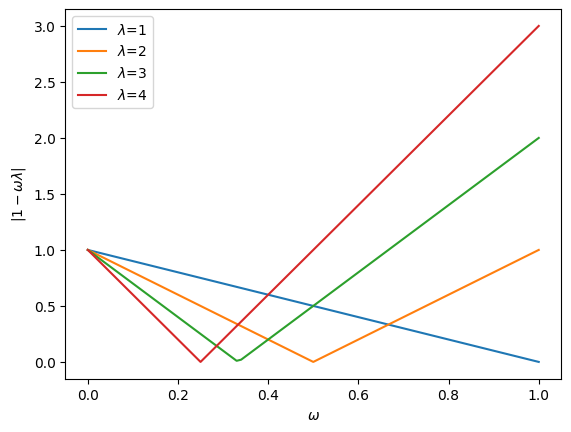

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def vplot(*lambdas: float, omega_min: float = 0, omega_max: float = 1):
    assert len(lambdas) >= 1
    assert omega_max > omega_min
    
    ax = plt.axes()
    
    omegas = np.linspace(omega_min, omega_max, int(101*abs(omega_max - omega_min)))
    for lam in lambdas:
        ax.plot(omegas,  abs(1 - omegas*lam), label=fr"$\lambda$={lam}")

    ax.legend()
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$|1-\omega\lambda|$")

vplot(1,2,3,4)

### P2. Feladat
Írjunk általános függvényt a fenti, $A = M-N$ felbontással adódó iterációkhoz, majd ezzel implementáljuk a tanult iterációkat.

Alkalmazzunk is ezek közül egy olyat, amit értelmes az
$$
\left[\matrix{2 & -1 \cr -1 & 2}\right] x= \left[ \matrix{1 \cr 3} \right]
$$
egyenlet megoldására. Addig iteráljunk, míg két szomszédos iterált $\| \cdot \|_2$ szerinti távolsága $10^{-4}$ alá nem csökken.

In [3]:
from dataclasses import dataclass
from functools import wraps
from typing import Callable

Matrix = np.ndarray
Vector = np.ndarray

@dataclass
class IterationResult:
    x: Vector
    success: bool
    abs_err: float
    rel_err: float
    step_num: int

@dataclass
class StoppingCondition:
    norm: Callable[(Vector,), float]
    atol: float
    rtol: float
    max_steps: int

def mn_iteration(
    extract_m: Callable[(Matrix,), Matrix],
    A: Matrix,
    b: Vector, 
    x0: Vector, 
    stopping_condition: StoppingCondition
) -> IterationResult:
    
    M = extract_m(A)
    N = M - A
    # M^{-1}N
    B = np.linalg.solve(M, N)
    # M^{-1}b
    r = np.linalg.solve(M, b)

    is_success = False
    x = x0
    for step_num in range(1, stopping_condition.max_steps+1):
        d = B@x + r - x;
        x = x + d
        
        # Ha d kicsi, azaz x_n es x_{n+1} kozel vannak, 
        # azaz x_n es f(x_n) kozel vannak,
        # azaz kozel vagyunk a fixponthoz.
        abs_err = stopping_condition.norm(d);

        if all([
            abs_err <= stopping_condition.atol,
            abs_err <= stopping_condition.rtol * stopping_condition.norm(x)
        ]):
            is_success = True
            break

    # tul sok lepes eseten sikertelen
    is_success &= (step_num <= stopping_condition.max_steps)

    return IterationResult(
        x,
        is_success,
        abs_err,
        abs_err/stopping_condition.norm(x),
        step_num
    )

In [4]:
from functools import partial

def make_jor_iteration(omega):
    return partial(mn_iteration, lambda A: 1/omega*np.diag(np.diag(A)))

def make_sor_iteration(omega):
    return partial(mn_iteration, lambda A: 1/omega*np.diag(np.diag(A)) + np.tril(A, -1))

In [5]:
jacobi_it = make_jor_iteration(omega=1)

In [7]:
A = np.array([
    [2, -1],
    [-1, 2],
])

b = np.array([1,3])
x0 = np.zeros((2,))

stopping_condition = StoppingCondition(
    partial(np.linalg.norm, ord=2), # nem kell a partial ha 2-es norma
    atol=1e-4,
    rtol=np.inf,
    max_steps=10**10,
)

In [8]:
iteration_result = jacobi_it(A, b, x0, stopping_condition)

In [9]:
iteration_result

IterationResult(x=array([1.66659546, 2.33328247]), success=True, abs_err=9.650505554713072e-05, rel_err=3.365642609394866e-05, step_num=15)

In [10]:
A @ iteration_result.x

array([0.99990845, 2.99996948])

### P3. Feladat

Írjunk programot, amit adott $\lambda_1, \lambda_2$ valós sajátértékek és $q_1, q_2$ egymásra merőleges sajátvektorok esetén ábrázolja a megfelelő kvadratikus alakot, azaz a

$$
\mathbb{R}^2 \ni x \mapsto x^T A x
$$
függvényt, ahol $A = \lambda_1 q_1 q_1^T + \lambda_2 q_2 q_2^T$. Ábrázoljunk a sajátértékek előjele szerinti lehetséges esetekre 1-1 példát.

In [ ]:
import itertools

def make_quad_form(lam1: float, lam2: float, q1: np.ndarray, q2: np.ndarray):
    assert abs(q1 @ q2)     < 1e-6
    # col. vectors
    q1 = q1.reshape((-1, 1))
    q2 = q2.reshape((-1, 1))

    Q = np.hstack((q1, q2))
    # normalize
    Q /= sum(Q*Q)

    # (2, 2)
    A = Q @ np.diag([lam1, lam2]) @ Q.T

    # (n, m) -> (n, m) -> (n, m)
    def evaluate_quadratic_form_over_meshgrid_output(X,Y):
        # (2, n, m)
        T = np.stack((X, Y), 0)


        # Z[j, k] = SUM_(a, b) { T[a, j, k] * A[a, b] * T[b, j, k] }
        Z = np.einsum("ajk, ab, bjk -> jk", T, A, T)
        
        # (n, m)        
        return Z

    return evaluate_quadratic_form_over_meshgrid_output

# igazából elég megadni 1 (nem null)vektort, arra merőleges vektort tudnuk csinálni
# sajátértékek helyett is elég csak az egyik hosszát állítani tudni
def qplot_compare(v: np.ndarray = np.array([0, 1.]), magnitude=1, resolution: int = 201):
    assert resolution >= 11
    assert int(resolution) == resolution
    assert v@v >= 1e-2
    assert magnitude > 0

    q1 = v
    q2 = np.array([[0, 1], [-1, 0]]) @ v
    
    xs = np.linspace(-1, 1, resolution)
    X, Y = np.meshgrid(xs, xs)

    fig, axes = plt.subplots(
        3, 3, 
        subplot_kw={"projection": "3d"}, 
        figsize=(10,10),
        sharex=True,
        sharey=True,
    )
    fig.suptitle('Kvadratikus alak grafikonja a 2 sajátérték előjele szerint')
    fig.supylabel(r'$\lambda_2$ előjele: -1, 0, 1')
    fig.supxlabel(r'$\lambda_1$ előjele: -1, 0, 1')

    # go through possible signs
    for s1, s2 in itertools.product([-1, 0, 1], [-1, 0, 1]):
        q = make_quad_form(s1*magnitude, s2, q1, q2)

        axis = axes[1-s1, s2+1]
        axis.plot_surface(X, Y, q(X, Y), cmap="jet")

        axis.axis('off')


In [ ]:
qplot_compare()

In [ ]:
## a 0 körül kevésbé para bola, kicsit más főiránnyal
# qplot_compare(v=np.array([1, 1.]), magnitude=0.5)

### P4. Feladat

Implementáljuk a gradiens-módszert az optimális lépéshosszválasztással az SZPD-baloldalú lineáris egyenletrendszer iteratív megoldására.

Alkalmazzuk is ezt a módszert az 
$$
\left[\matrix{2 & -1 \cr -1 & 2}\right] x= \left[ \matrix{1 \cr 3} \right]
$$
egyenlet megoldására. Addig iteráljunk, míg két szomszédos iterált $\| \cdot \|_\infty$ szerinti távolsága $10^{-6}$ alá nem csökken.

In [ ]:
def grad_descent(
    A: Matrix,
    b: Vector, 
    x0: Vector, 
    stopping_condition: StoppingCondition
) -> IterationResult:

    is_success = False
    x = x0
    for step_num in range(1, stopping_condition.max_steps+1):
        # gradiens
        r = A@x - b
        # lepeshossz
        omega = r@r / (1e-16 + r@(A@r))

        d = - omega*r
        x = x + d
        
        # Ha a gradiens kicsi, akkor kozel vagyunk a fgv. szelsoertekhelyehez
        abs_err = stopping_condition.norm(d);
        if all([
            abs_err <= stopping_condition.atol,
            abs_err <= stopping_condition.rtol * stopping_condition.norm(x)
        ]):
            is_success = True
            break

    # tul sok lepes eseten sikertelen
    is_success &= (step_num <= stopping_condition.max_steps)

    return IterationResult(
        x,
        is_success,
        abs_err,
        abs_err/stopping_condition.norm(x),
        step_num
    )

In [ ]:
A = np.array([
    [2, -1],
    [-1, 2],
])
b = np.array([1,3])
x0 = np.zeros((2,))
stopping_condition = StoppingCondition(
    partial(np.linalg.norm, ord=np.inf),
    atol=1e-6,
    rtol=np.inf,
    max_steps=10**10,
)

res = grad_descent(A, b, x0, stopping_condition)

In [ ]:
res

In [ ]:
A@res.x